In [1]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from modules import *
import json

In [2]:
gpt2 = {'l': 1024, 'e': 1600, 'h': 32, 'depth': 48}
gpt3 = {'l': 2048, 'e': 12288, 'h': 256, 'depth': 96}
gpt3_lowdepth = {'l': 2048, 'e': 12288, 'h': 256, 'depth': 96 // 8}
vit_era5 = {'l': 64800, 'e': 2048, 'h': 64, 'depth': 24}
### model
model = gpt3
b = 1
l = model['l']
e = model['e']
f = 4 * e
h = model['h']
depth = model['depth']
print("model: batch size = {}, seq length = {}, embed = {}, attention heads = {}, depth = {}".format(b, l, e, h, depth))

model: batch size = 1, seq length = 2048, embed = 12288, attention heads = 256, depth = 96


In [3]:
with open('config.json', 'r') as file:
    system = json.load(file)

In [4]:
def print_df(df_mlp, df_sa, time_unit = 60.0, unit_name= 'min'):
    cols = df_mlp.columns.tolist()
    layer_track_cols = ['activation_buffer', 'weights_mem', 
                        'weights_grad_mem', 'flops_fwd', 'flops_bwd', 
                        't_fwd', 't_fwd_comm', 't_bwd', 't_bwd_comm']
    display(df_mlp[cols])
    display(df_mlp[layer_track_cols].sum() * depth)
    display(df_sa[cols])
    display(df_sa[layer_track_cols].sum() * depth)
    # time for iteration in seconds 
    t_itr = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum() + df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum()) * depth
    print('time for 1 itr = {} {}'.format(t_itr/time_unit,unit_name))

    f1 = 3 # 1 fp16 wt, 1 fp32 copy
    f2 = 5 # 1 fp16 grad, 2 fp32 means and variances
    mem = (df_mlp['weights_mem'].sum() * f1 + df_mlp['weights_grad_mem'].sum() * f2 + df_mlp['activation_buffer'].sum() +
           df_sa['weights_mem'].sum() * f1 + df_sa['weights_grad_mem'].sum() * f2 + df_sa['activation_buffer'].sum()) * depth
    print('mem consumed = {}'.format(mem))

In [5]:
m1 = 64
system['nvlink_size'] = 8
t1 = 'nvlink' if m1 <= system['nvlink_size'] else 'ib'
t1 = 'mixed'
system['formula'] = False
nv = min(m1,system['nvlink_size'])
df_mlp = mlp_1d(b, l, e, f, depth, parallelism={'m': m1}, topology={'t': t1},nv_domain={'m': nv},system=system)
df_sa = sa_1d(b, l, e, h, depth, parallelism={'m': m1}, topology={'t': t1}, flash_attention=False,nv_domain={'m': nv},system=system)
print_df(df_mlp, df_sa)

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,fc1,0.018874,0.018874,3.865313e-02,0.050332,0.000000,reducescatter,7.727481e-02,0.050332,reducescatter,0.000124,0.000000,2.662634,0.000751,0.000503,2.661551,0.000875
1,fc1-bias,0.000002,0.000002,1.572864e-06,0.000000,0.000000,none,1.572864e-06,0.000000,allreduce,0.000002,0.000000,0.009963,0.000002,0.000000,0.009963,0.000004
2,act1,0.000000,0.000000,1.572864e-06,0.003146,0.000000,none,1.572864e-06,0.000000,none,0.000004,0.000000,0.004984,0.000006,0.000000,0.003323,0.000010
3,dpr1,0.000000,0.000000,1.572864e-06,0.001573,0.000000,none,1.572864e-06,0.000000,none,0.000005,0.000000,0.003987,0.000005,0.000000,0.003987,0.000010
4,fc2,0.018874,0.018874,3.862954e-02,0.003146,0.050332,reducescatter,7.729840e-02,0.000000,reducescatter,0.000627,0.000503,2.661009,0.000248,0.000000,2.662363,0.000875
5,fc2-bias,0.000025,0.000025,2.516582e-05,0.000000,0.000000,none,2.516582e-05,0.000000,allreduce,0.000032,0.000000,0.009963,0.000032,0.000000,0.009963,0.000065
6,dpr2,0.000000,0.000000,3.932160e-07,0.000393,0.000000,none,3.932160e-07,0.000000,none,0.000001,0.000000,0.003987,0.000001,0.000000,0.003987,0.000003
7,ln1,0.000049,0.000049,3.538944e-06,0.000786,0.050332,allgather,4.718464e-06,0.050332,reducescatter,0.000504,0.000503,0.043493,0.000506,0.000503,0.023627,0.001010


activation_buffer     5.700059
weights_mem           3.631104
weights_grad_mem      3.631104
flops_fwd             7.422383
flops_bwd            14.842388
t_fwd                 0.124815
t_fwd_comm            0.096637
t_bwd                 0.148936
t_bwd_comm            0.096637
dtype: float64

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,qkv,0.014156,0.014156,2.898985e-02,0.050332,0.000000,reducescatter,5.794981e-02,0.050332,reducescatter,0.000093,0.000000,2.161432,0.000689,0.000503,2.160318,0.000782
1,logits,0.000000,0.000000,1.593836e-03,0.001573,0.000000,none,3.220439e-03,0.000000,none,0.000023,0.000000,0.226139,0.000045,0.000000,0.228463,0.000068
2,softmax,0.000000,0.000000,5.026611e-05,0.033554,0.000000,none,6.704333e-05,0.000000,none,0.000043,0.000000,0.014932,0.000065,0.000000,0.013278,0.000108
3,dpr_at,0.000000,0.000000,1.677722e-05,0.016777,0.000000,none,1.677722e-05,0.000000,none,0.000054,0.000000,0.003987,0.000054,0.000000,0.003987,0.000108
4,attend,0.000000,0.000000,1.610220e-03,0.034341,0.000000,none,3.204055e-03,0.000000,none,0.000023,0.000000,0.228463,0.000045,0.000000,0.227301,0.000068
5,vproj,0.004719,0.004719,9.638511e-03,0.000786,0.050332,reducescatter,1.932460e-02,0.000000,reducescatter,0.000539,0.000503,0.860332,0.000072,0.000000,0.862456,0.000611
6,vproj-bias,0.000025,0.000025,2.516582e-05,0.000000,0.000000,none,2.516582e-05,0.000000,allreduce,0.000032,0.000000,0.009963,0.000032,0.000000,0.009963,0.000065
7,dpr_v,0.000000,0.000000,3.932160e-07,0.000393,0.000000,none,3.932160e-07,0.000000,none,0.000001,0.000000,0.003987,0.000001,0.000000,0.003987,0.000003
8,ln2,0.000049,0.000049,3.538944e-06,0.000786,0.050332,allgather,4.718464e-06,0.050332,reducescatter,0.000504,0.000503,0.043493,0.000506,0.000503,0.023627,0.001010


activation_buffer    13.300138
weights_mem           1.819017
weights_grad_mem      1.819017
flops_fwd             4.025141
flops_bwd             8.046049
t_fwd                 0.125993
t_fwd_comm            0.096637
t_bwd                 0.144906
t_bwd_comm            0.096637
dtype: float64

time for 1 itr = 0.00907749647776641 min
mem consumed = 62.601166848000005


In [6]:
m1 = 64
system['nvlink_size'] = 8
t1 = 'nvlink' if m1 <= system['nvlink_size'] else 'ib'
t1 = 'mixed'
system['formula'] = True
nv = min(m1,system['nvlink_size'])
df_mlp = mlp_1d(b, l, e, f, depth, parallelism={'m': m1}, topology={'t': t1},nv_domain={'m': nv},system=system)
df_sa = sa_1d(b, l, e, h, depth, parallelism={'m': m1}, topology={'t': t1}, flash_attention=False,nv_domain={'m': nv},system=system)
print_df(df_mlp, df_sa)

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,fc1,0.018874,0.018874,3.865313e-02,0.050332,0.000000,reducescatter,7.727481e-02,0.050332,reducescatter,0.000124,0.00000,2.662634,0.000708,0.00046,2.661551,0.000831
1,fc1-bias,0.000002,0.000002,1.572864e-06,0.000000,0.000000,none,1.572864e-06,0.000000,allreduce,0.000002,0.00000,0.009963,0.000002,0.00000,0.009963,0.000004
2,act1,0.000000,0.000000,1.572864e-06,0.003146,0.000000,none,1.572864e-06,0.000000,none,0.000004,0.00000,0.004984,0.000006,0.00000,0.003323,0.000010
3,dpr1,0.000000,0.000000,1.572864e-06,0.001573,0.000000,none,1.572864e-06,0.000000,none,0.000005,0.00000,0.003987,0.000005,0.00000,0.003987,0.000010
4,fc2,0.018874,0.018874,3.862954e-02,0.003146,0.050332,reducescatter,7.729840e-02,0.000000,reducescatter,0.000584,0.00046,2.661009,0.000248,0.00000,2.662363,0.000831
5,fc2-bias,0.000025,0.000025,2.516582e-05,0.000000,0.000000,none,2.516582e-05,0.000000,allreduce,0.000032,0.00000,0.009963,0.000032,0.00000,0.009963,0.000065
6,dpr2,0.000000,0.000000,3.932160e-07,0.000393,0.000000,none,3.932160e-07,0.000000,none,0.000001,0.00000,0.003987,0.000001,0.00000,0.003987,0.000003
7,ln1,0.000049,0.000049,3.538944e-06,0.000786,0.050332,allgather,4.718464e-06,0.050332,reducescatter,0.000461,0.00046,0.043493,0.000462,0.00046,0.023627,0.000923


activation_buffer     5.700059
weights_mem           3.631104
weights_grad_mem      3.631104
flops_fwd             7.422383
flops_bwd            14.842388
t_fwd                 0.116469
t_fwd_comm            0.088291
t_bwd                 0.140591
t_bwd_comm            0.088291
dtype: float64

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,qkv,0.014156,0.014156,2.898985e-02,0.050332,0.000000,reducescatter,5.794981e-02,0.050332,reducescatter,0.000093,0.00000,2.161432,0.000646,0.00046,2.160318,0.000739
1,logits,0.000000,0.000000,1.593836e-03,0.001573,0.000000,none,3.220439e-03,0.000000,none,0.000023,0.00000,0.226139,0.000045,0.00000,0.228463,0.000068
2,softmax,0.000000,0.000000,5.026611e-05,0.033554,0.000000,none,6.704333e-05,0.000000,none,0.000043,0.00000,0.014932,0.000065,0.00000,0.013278,0.000108
3,dpr_at,0.000000,0.000000,1.677722e-05,0.016777,0.000000,none,1.677722e-05,0.000000,none,0.000054,0.00000,0.003987,0.000054,0.00000,0.003987,0.000108
4,attend,0.000000,0.000000,1.610220e-03,0.034341,0.000000,none,3.204055e-03,0.000000,none,0.000023,0.00000,0.228463,0.000045,0.00000,0.227301,0.000068
5,vproj,0.004719,0.004719,9.638511e-03,0.000786,0.050332,reducescatter,1.932460e-02,0.000000,reducescatter,0.000496,0.00046,0.860332,0.000072,0.00000,0.862456,0.000568
6,vproj-bias,0.000025,0.000025,2.516582e-05,0.000000,0.000000,none,2.516582e-05,0.000000,allreduce,0.000032,0.00000,0.009963,0.000032,0.00000,0.009963,0.000065
7,dpr_v,0.000000,0.000000,3.932160e-07,0.000393,0.000000,none,3.932160e-07,0.000000,none,0.000001,0.00000,0.003987,0.000001,0.00000,0.003987,0.000003
8,ln2,0.000049,0.000049,3.538944e-06,0.000786,0.050332,allgather,4.718464e-06,0.050332,reducescatter,0.000461,0.00046,0.043493,0.000462,0.00046,0.023627,0.000923


activation_buffer    13.300138
weights_mem           1.819017
weights_grad_mem      1.819017
flops_fwd             4.025141
flops_bwd             8.046049
t_fwd                 0.117648
t_fwd_comm            0.088291
t_bwd                 0.136560
t_bwd_comm            0.088291
dtype: float64

time for 1 itr = 0.008521136797766412 min
mem consumed = 62.601166848000005


In [7]:
m1 = 8
m2 = 8
t2 = 'nvlink'
t1 = 'ib'
df_mlp = mlp_2d(b, l, e, f, depth, parallelism={'m1': m1, 'm2': m2}, topology={'t1': t1, 't2': t2}, nv_domain={'m1': 1, 'm2': 8}, system=system)
df_sa = sa_2d(b, l, e, h, depth, parallelism={'m1': m1, 'm2': m2}, topology={'t1': t1, 't2': t2},nv_domain={'m1': 1, 'm2': 8},system=system)
print_df(df_mlp, df_sa)

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,fc1,0.018874,0.018874,3.865471e-02,0.000786,"[0.006291456000000001, 0.15099494400000002]","[broadcast, broadcast]",7.723077e-02,"[0.15099494400000002, 0.006291456000000001, 0....","[broadcast, reduce, broadcast, reduce]",4.674973e-03,0.004551,1.055915,0.004675,0.004427,1.054841,0.009350
1,fc1-bias,0.000012,0.000012,1.572864e-06,0.000000,0,none,1.572864e-06,0.000012,allreduce,2.030878e-06,0.000000,0.009929,0.000123,0.000121,0.009929,0.000125
2,act1,0.000000,0.000000,1.572864e-06,0.003146,0,none,1.572864e-06,0,none,4.045952e-06,0.000000,0.004984,0.000006,0.000000,0.003323,0.000010
3,dpr1,0.000000,0.000000,1.572864e-06,0.001573,0,none,1.572864e-06,0,none,5.057441e-06,0.000000,0.003987,0.000005,0.000000,0.003987,0.000010
4,fc2,0.018874,0.018874,3.865471e-02,0.003146,"[0.025165824000000003, 0.15099494400000002]","[broadcast, broadcast]",7.722133e-02,"[0.15099494400000002, 0.025165824000000003, 0....","[broadcast, reduce, broadcast, reduce]",4.674973e-03,0.004551,1.055915,0.004675,0.004427,1.054712,0.009350
5,fc2-bias,0.000003,0.000003,3.932160e-07,0.000000,0,none,3.932160e-07,0.000003,allreduce,5.077196e-07,0.000000,0.009929,0.000121,0.000121,0.009929,0.000122
6,dpr2,0.000000,0.000000,3.932160e-07,0.000393,0,none,3.932160e-07,0,none,1.264360e-06,0.000000,0.003987,0.000001,0.000000,0.003987,0.000003
7,ln1,0.000001,0.000001,5.898240e-07,0.000131,0.000001,allreduce,7.854080e-07,0.000007,allreduce,2.859237e-04,0.000286,0.044508,0.000287,0.000286,0.023855,0.000573


activation_buffer     0.880804
weights_mem           3.625452
weights_grad_mem      3.625452
flops_fwd             7.422289
flops_bwd            14.828005
t_fwd                 0.926283
t_fwd_comm            0.901240
t_bwd                 0.949752
t_bwd_comm            0.900755
dtype: float64

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,qkv,0.014156,0.014156,2.899103e-02,0.000786,"[0.006291456000000001, 0.113246208]","[broadcast, broadcast]",5.792229e-02,"[0.113246208, 0.006291456000000001, 0.00629145...","[broadcast, reduce, broadcast, reduce]",3.542511e-03,0.003450,1.043916,0.003543,0.003357,1.042840,0.007085
1,logits,0.000000,0.000000,1.476395e-03,0.001573,"[0.006291456000000001, 0.268435456]","[broadcast, reduce]",3.220439e-03,"[0.536870912, 0.012582912000000002]","[broadcast, broadcast]",3.338687e-04,0.000153,0.026184,0.000523,0.000161,0.028558,0.000856
2,softmax,0.000000,0.000000,4.980736e-05,0.033554,0.001049,allreduce,6.658458e-05,0.001049,allreduce,3.985085e-04,0.000355,0.014796,0.000420,0.000355,0.013187,0.000819
3,dpr_at,0.000000,0.000000,1.677722e-05,0.016777,0,none,1.677722e-05,0,none,5.394603e-05,0.000000,0.003987,0.000054,0.000000,0.003987,0.000108
4,attend,0.000000,0.000000,1.610613e-03,0.034341,"[0.268435456, 0.006291456000000001]","[broadcast, broadcast]",3.083862e-03,"[0.006291456000000001, 0.268435456, 0.26843545...","[broadcast, reduce, broadcast, reduce]",3.338687e-04,0.000153,0.028565,0.000399,0.000037,0.027347,0.000732
5,vproj,0.004719,0.004719,9.663676e-03,0.000786,"[0.006291456000000001, 0.037748736000000005]","[broadcast, broadcast]",1.930533e-02,"[0.037748736000000005, 0.006291456000000001, 0...","[broadcast, reduce, broadcast, reduce]",1.277587e-03,0.001245,0.956923,0.001278,0.001213,0.955833,0.002555
6,vproj-bias,0.000003,0.000003,3.932160e-07,0.000000,0,none,3.932160e-07,0.000003,allreduce,5.077196e-07,0.000000,0.009929,0.000121,0.000121,0.009929,0.000122
7,dpr_v,0.000000,0.000000,3.932160e-07,0.000393,0,none,3.932160e-07,0,none,1.264360e-06,0.000000,0.003987,0.000001,0.000000,0.003987,0.000003
8,ln2,0.000001,0.000001,5.898240e-07,0.000131,0.000001,allreduce,7.854080e-07,0.000007,allreduce,2.859237e-04,0.000286,0.044508,0.000287,0.000286,0.023855,0.000573


activation_buffer    8.480883
weights_mem          1.812333
weights_grad_mem     1.812333
flops_fwd            4.013729
flops_bwd            8.027218
t_fwd                0.597887
t_fwd_comm           0.541653
t_bwd                0.635945
t_bwd_comm           0.530908
dtype: float64

time for 1 itr = 0.05183109858694205 min
mem consumed = 52.86395904


In [8]:
def plot(n_gpus, system, axs, lgnd=['MLP', 'SA'], lgnd_tot=['nvlink1'], lfmt="-"):
    t_mlp = []
    t_sa = []
    t_itr = []

    for n in n_gpus:
        m1 = n 
        if n <= system['nvlink_size']:
            t1 = 'nvlink' 
        if n > system['nvlink_size']:
            t1 = 'mixed'
        if system['nvlink_size'] == 1:
            t1 = 'ib'
        
#         df_mlp = mlp_1d(b, l, e, f, depth, parallelism={'m': m1}, topology={'t': t1})
#         df_sa = sa_1d(b, l, e, h, depth, parallelism={'m': m1}, topology={'t': t1}, flash_attention=True)
        
        nv = min(m1,system['nvlink_size'])
#         print(nv,m1,system['nvlink_size'],t1)
        df_mlp = mlp_1d(b, l, e, f, depth, parallelism={'m': m1}, topology={'t': t1},nv_domain={'m': nv},system=system)
        df_sa = sa_1d(b, l, e, h, depth, parallelism={'m': m1}, topology={'t': t1}, flash_attention=True,nv_domain={'m': nv},system=system)


        t_mlp_ = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum() * depth)
        t_sa_ = (df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum() * depth)
        t_itr.append(t_mlp_ + t_sa_)
        t_mlp.append(t_mlp_)
        t_sa.append(t_sa_)

    
    ax = axs[0]
    ax.plot(n_gpus, t_mlp, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_sa, lfmt, linewidth=2, c=c2)
#     ax.set_yscale('log')
#     ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-6)
    ax.set_ylabel('Time', fontsize=fsz)    
    ax.legend(lgnd, fontsize=fsz-6)
    
    ax = axs[1]
    ax.plot(n_gpus, t_itr, lfmt, linewidth=2)
#     ax.set_yscale('log')
#     ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-6)
    ax.set_ylabel('Total time', fontsize=fsz)
    ax.legend(lgnd_tot, fontsize=fsz-6)
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))

{'matrix_flops_fp16': 312, 'vector_flops_fp32': 19.5, 'vector_flops_fp16': 78, 'hbm_bandwidth': 1555, 'nvlink_bandwidth': 300, 'ib_bandwidth': 100, 'ib_latency': 4.3e-05, 'nvlink_size': 8, 'nvlink_latency': 4.3e-05, 'empirical': False, 'formula': True, 'element_size': 2e-09, 'mask_element_size': 1e-09, 'flops_units': 1e-12}


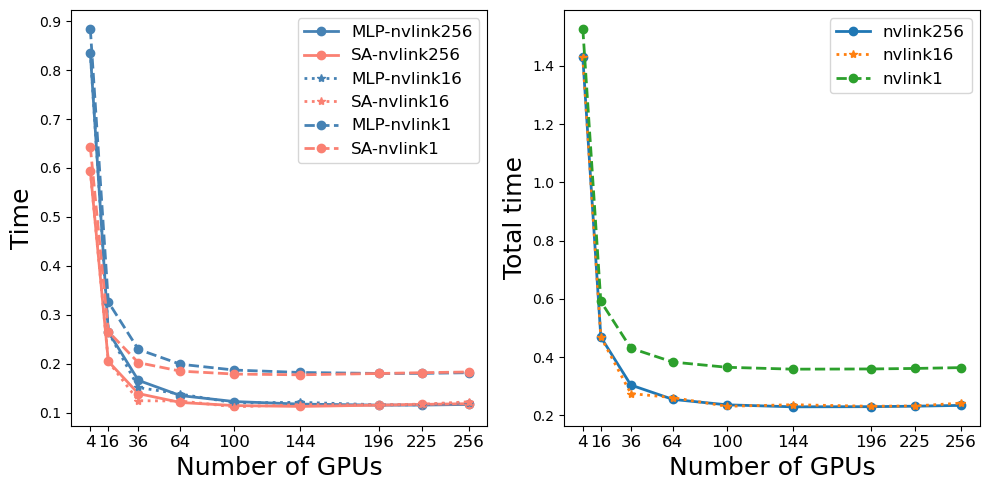

In [9]:
# Sweeps
print(system)
### model parallelism
n_gpus = [4, 16, 36, 64, 100, 144, 196, 225, 256]
with open('config.json', 'r') as file:
    system = json.load(file)
    
# system['nvlink_latency']=0.00001
# system['ib_latency']=0.00001     
fig, axs = plt.subplots(1,2,figsize=(10,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 18

nvs = 256
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot = ["nvlink{}".format(nvs)]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o-")
nvs = 16
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="*:")
system['nvlink_size'] = 1
lgnd += ["MLP-nvlink1", "SA-nvlink1"]
lgnd_tot += ["nvlink1"]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o--")

In [10]:
# def set_gpus(n, nvs):
#     parallelism = {}
#     topology = {}
#     factors_of_n = [[i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0]
#     best_factor = factors_of_n[-1]
#     parallelism['m1'] = best_factor[0]
#     parallelism['m2'] = best_factor[1]
    
#     if n <= nvs: #p=n, q=nvs, m1=m2=sqrt(n), q=q1q2
#         # set all gpus within nvlink
#         topology['t1'] = 'nvlink'
#         topology['t2'] = 'nvlink'
#     elif
    
#     else:
#         topology['t1'] = 'ib' # changed to mixed
#         topology['t2'] = 'nvlink' if parallelism['m2'] <= nvs else 'ib' # change to mixed
        
#     # print(parallelism, topology)
#     return parallelism, topology

def plot_2d(n_gpus, system, axs, lgnd=['MLP', 'SA'], lgnd_tot=['nvlink1'], lfmt="-"):
    
    t_mlp = []
    t_sa = []
    t_itr = []

    for n in n_gpus:
        
        m1 = int(np.sqrt(n))
        m2 =  m1
        
        nv2 = 1
        nv1 = system['nvlink_size']
        
        t2= 'ib'
        
        if m1 <= nv1:
            t1 = 'nvlink' 
        if m1 > nv1:
            t1 = 'mixed'
        if nv1 == 1:
            t1 = 'ib'
            
        parallelism={'m1': m1, 'm2': m2}; topology={'t1': t1, 't2': t2}; nv_domain={'m1': nv1, 'm2': nv2}
        
        
        df_mlp = mlp_2d(b, l, e, f, depth, parallelism=parallelism, topology=topology, 
                        nv_domain=nv_domain, system=system)
        df_sa = sa_2d(b, l, e, h, depth, parallelism=parallelism, topology=topology,
                      nv_domain=nv_domain,system=system)

        
#         df_mlp = mlp_2d(b, l, e, f, depth, parallelism=parallelism, topology=topology)
#         df_sa = sa_2d(b, l, e, h, depth, parallelism=parallelism, topology=topology)

        t_mlp_ = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum() * depth)
        t_sa_ = (df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum() * depth)
        t_itr.append(t_mlp_ + t_sa_)
        t_mlp.append(t_mlp_)
        t_sa.append(t_sa_)

    
    ax = axs[0]
    ax.plot(n_gpus, t_mlp, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_sa, lfmt, linewidth=2, c=c2)
#     ax.set_yscale('log')
#     ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-6)
    ax.set_ylabel('Time', fontsize=fsz)    
    ax.legend(lgnd, fontsize=fsz-6)
    
    ax = axs[1]
    ax.plot(n_gpus, t_itr, lfmt, linewidth=2)
#     ax.set_yscale('log')
#     ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-6)
    ax.set_ylabel('Total time', fontsize=fsz)
    ax.legend(lgnd_tot, fontsize=fsz-6)
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))

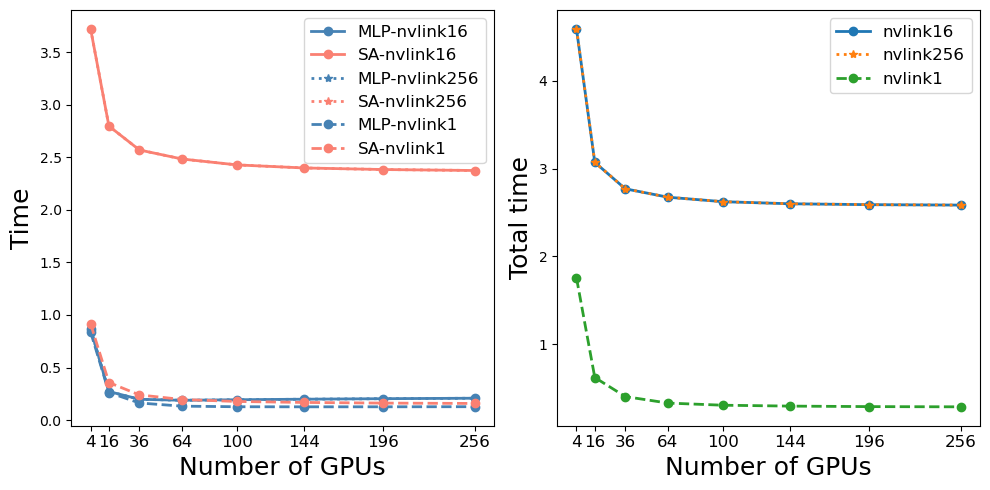

In [12]:
# Sweeps
### model parallelism
n_gpus = [4, 16, 36, 64, 100, 144, 196, 256]
with open('config.json', 'r') as file:
    system = json.load(file)
fig, axs = plt.subplots(1,2,figsize=(10,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 18

lgnd = []
lgnd_tot = []
nvs = 16
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot = ["nvlink{}".format(nvs)]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o-")
nvs = 256
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="*:")
system['nvlink_size'] = 1
lgnd += ["MLP-nvlink1", "SA-nvlink1"]
lgnd_tot += ["nvlink1"]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o--")